In [1]:
import mosaic

from stride import *
from stride.problem import *
from stride.utils import wavelets

%matplotlib notebook

Before we start executing our forward propagation, we need to start up the mosaic runtime:

In [2]:
await mosaic.interactive('on')
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 140265941601552, uid=head, address=155.198.98.57, port=3001, state=listening>
MONITOR         Listening at <CommsManager object at 140268187003152, uid=monitor, address=155.198.98.57, port=3004, state=listening>
NODE:0          Listening at <CommsManager object at 140268186958352, uid=node:0, address=155.198.98.57, port=3005, state=listening>
WORKER:0:0      Listening at <CommsManager object at 140268186756176, uid=worker:0:0, address=155.198.98.57, port=3007, state=listening>


Everything in stride is defined over a certain spatio-temporal grid.

Then, our first step is to define this grid by creating a `Space` and `Time` objects that define the discretisation of our grid.

In [3]:
# Create the grid
shape = (356, 385)
extra = (50, 50)
absorbing = (40, 40)
spacing = (0.5e-3, 0.5e-3)

space = Space(shape=shape,
              extra=extra,
              absorbing=absorbing,
              spacing=spacing)

start = 0.
step = 0.08e-6
num = 2500

time = Time(start=start,
            step=step,
            num=num)

Based on this grid, we can define a `Problem`. In stride, a `Problem` object encapsulates all the information that is needed to describe a tomography experiment.

In its most basic form, the problem is given a name and the grid we have just created:

In [4]:
# Create problem
problem = Problem(name='anastasio2D',
                  space=space, time=time)

We can now start defining each of the components of the `Problem`.

Firstly, we need to define the physical properties that describe the medium in which our experiment is taking place.

Because we are going to run the default isotropic acoustic wave equation with constant density, we only need to define the longitudinal speed of sound of our medium. The longitudinal speed of sound is a scalar field, for which we can use the class `ScalarField`:

In [5]:
# Create medium
# Field(..., grid=problem.grid) is equivalent to Field(..., space=space, time=time)
vp = ScalarField(name='vp', grid=problem.grid)
vp.load('data/anastasio2D-TrueModel.h5')

problem.medium.add(vp)

Next, we need to define the types of ultrasound transducers that we will use.

Because we are happy with using omnidirectional point sources and receivers, we can configure the default transducers:

In [6]:
# Create transducers
problem.transducers.default()

In order to use the transducers in our ultrasound acquisition, we need to add them to a `Geometry`. The `Geometry` defines the spatial location of each transducer within our grid.

In this case, we will generate a default elliptical geometry with 128 locations for our point transducers:

In [7]:
# Create geometry
num_locations = 128
problem.geometry.default('elliptical', num_locations)

Finally, we need to define what transducers in the geometry act as sources or as receivers. We do this by defining the `Acquisition`.

An `Acquisition` is composed by a number of `Shot`s. Each `Shot` contains one or more transducer locations that act as sources and one or more transducer locations acting as receivers.

By configuring the default acquisition, we generate as many `Shot`s as locations we have in our geometry. In each `Shot`, one transducer location acts as a source while all of them act as receivers. 

In [8]:
# Create acquisitions
problem.acquisitions.default()

We can finish configurng our `Acquisition` by defining the excitation signal that the sources in each `Shot` will fire.

Here, we use a three-cycle tone burst as an excitation signal:

In [9]:
# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles,
                                                   time.num, time.step)

Once complete, we can review our `Problem` by plotting its components:

<IPython.core.display.Javascript object>


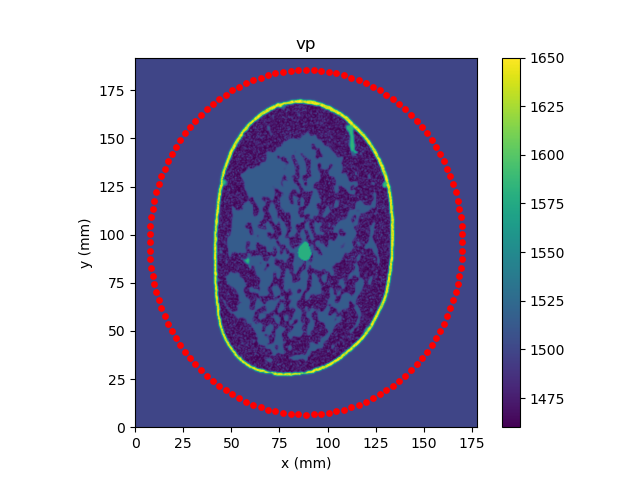

<IPython.core.display.Javascript object>


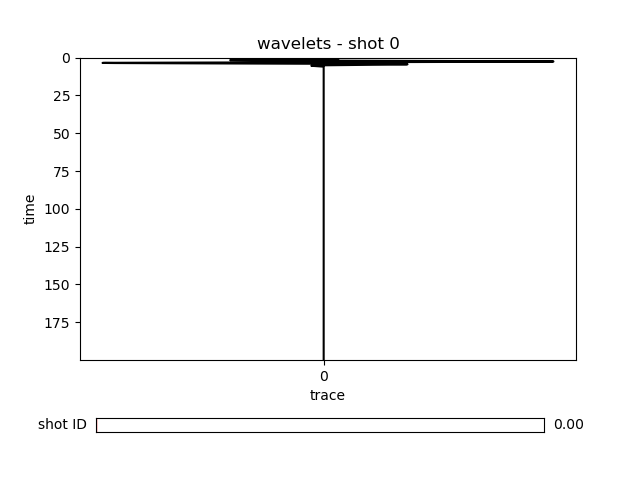

In [10]:
# Plot
problem.plot()

Once we have generated our problem, we can create a partial differential equation (PDE) on which to run our forward problem. In this case, we show the isotropic acoustic wave equation.

We instantiate our PDE using `.remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [11]:
pde = physics.IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

Now, we are ready to execute the problem forward:

In [ ]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    # Append the newly retrieved traces to a file on disk
    shot.append_observed(path=problem.output_folder,
                         project_name=problem.name)

    runtime.logger.info('Appended traces for shot %d to observed file' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward`:

In [ ]:
# Run default forward workflow
await forward(problem, pde, vp)

The results of running the problem forwar are now held by every shot. We can access them through `shot.observed.data`. At the same time, this data has been saved to disk under `anastasio2D-Acquisitions.h5`.

Before closing, we should tear down the mosaic runtime.

In [13]:
await mosaic.interactive('off')